# Chapter 5. Backpropagation

In [1]:
# Addition and Multiplication node
import numpy as np

class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self,x,y):
        self.x = x
        self.y = y
        
        return x*y
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy
    
class AddLayer:
    def __init__(self):
        pass

    
    def forward(self,x,y):
        return x + y
    
    def backward(self, dout):
        dx = dout * 1.0
        dy = dout * 1.0
        
        return dx, dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# Forward propagation
apple_price = mul_apple_layer.forward(apple,apple_num)
price = mul_tax_layer.forward(apple_price,tax)

print(price)

220.00000000000003


In [3]:
# Backward propagation
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


In [4]:
# Apple + Orange buying

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# Forward
apple_price = mul_apple_layer.forward(apple,apple_num)
orange_price = mul_orange_layer.forward(orange,orange_num)
total_price = add_apple_orange_layer.forward(apple_price,orange_price)
price = mul_tax_layer.forward(total_price,tax)

print(price)
print("------"*3)

# Backward
dprice = 1
dtotal_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dtotal_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
------------------
110.00000000000001 2.2 3.3000000000000003 165.0 650


In [5]:
# Activation function layer
# ReLu layer
class Relu:
    def __init__(self):
        self.mask = None
        
    # forward : if value in x is smaller or equal to 0, convert it to 0.
    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    # backward : if value in x at the forward <= 0, derivative is 0.
    # else, the gradient is propagated without change of value. 
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

# Sigmoid layer

class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self,x):
        out = 1. / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self,dout):
        dx = dout * self.out * (1.0 - self.out)
        return dx

In [6]:
# Affine layer
# output = X * W + b (weight * input + bias)
# X : (# data, input_dim), W : (input_dim, output_dim or hidden_dim), b : output or hidden_dim

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self,x):
        self.x = x
        out = np.dot(x,self.W) + self.b
        
        return out
    
    def backward(self,dout):
        self.db = np.sum(dout, axis=0) # (N,b.size) => (b.size) : sum over N data
        self.dW = np.dot(self.x.T, dout)
        dx = np.dot(dout, self.W.T)
        
        return dx
    

In [14]:
# Softmax function with loss (cross-entropy) layer
import sys, os
sys.path.append(os.pardir)
from common.functions import softmax, cross_entropy


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self,x,t):
        self.y = softmax(x)
        self.t = t
        self.loss = cross_entropy(self.y, self.t)
        return self.loss

    def backward(self,dout):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

In [15]:
# TwoLayer class with Layers defined above

import numpy as np
import sys, os
sys.path.append(os.pardir)

from common.functions import *
from common.gradient import numerical_grad

from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
                weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # Layers defines here
        # Here we use OrderedDict to set order of layers
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'],self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        # Forward operation in layers.
        # It does not execute Softmax and Loss layer propagation.
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
    
    
    # t : answer label
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        # Among the output and answer label, pick the largest ones. 
        # As the value hierarchy does not change after softmax operation, 
        # we just take the maximum value index here so that we aviod additional operation.
        y = np.argmax(y, axis=1)
        
        if t.ndim != 1: t = np.argmax(t, axis=1)
        
        accuracy = np.sum( y == t ) / float(x.shape[0])
        return accuracy
    
    def numerical_grad(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
 
        grads['W1'] = numerical_grad(loss_W, self.params['W1'])

        grads['b1'] = numerical_grad(loss_W, self.params['b1'])

        grads['W2'] = numerical_grad(loss_W, self.params['W2'])

        grads['b2'] = numerical_grad(loss_W, self.params['b2'])

        
        return grads
    

    def grad(self, x, t):
        
        self.loss(x, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())[::-1]
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

In [17]:
# implementation test

import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train) , (x_test, t_test) = \
    load_mnist(flatten=True, normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_grad(x_batch,t_batch)
grad_backprop = network.grad(x_batch,t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key]-grad_numerical[key]))
    print(key + ":" + str(diff))


W1:4.6461922793583853e-10
b1:2.9312840204610837e-09
W2:6.663991405068731e-09
b2:1.391451511206787e-07


In [22]:
# training

import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train) , (x_test, t_test) = \
    load_mnist(flatten=True, normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

iter_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iter_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # backpropagation => gradient
    grad = network.grad(x_batch,t_batch)
    
    # Updating hyperparameters
    for key in network.params.keys():
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train,t_train)
        test_acc = network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.11181666666666666, 0.1109
train acc, test acc | 0.90645, 0.9105
train acc, test acc | 0.9259166666666667, 0.9275
train acc, test acc | 0.9392, 0.9398
train acc, test acc | 0.94775, 0.9449
train acc, test acc | 0.9549666666666666, 0.9519
train acc, test acc | 0.95845, 0.9555
train acc, test acc | 0.9632666666666667, 0.9582
train acc, test acc | 0.9665166666666667, 0.962
train acc, test acc | 0.9686166666666667, 0.9629
train acc, test acc | 0.9708333333333333, 0.9652
train acc, test acc | 0.9713166666666667, 0.9653
train acc, test acc | 0.9747333333333333, 0.9667
train acc, test acc | 0.9764666666666667, 0.9693
train acc, test acc | 0.9774, 0.9682
train acc, test acc | 0.9791666666666666, 0.9698
train acc, test acc | 0.978, 0.9687


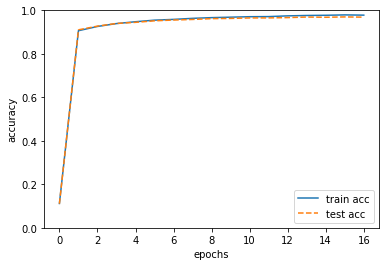

In [23]:
import matplotlib.pyplot as plt

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()